# Lab 5: Wide and Deep Networks

## Preparation

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read the data
data = 'healthcare-dataset-stroke-data.csv'
df = pd.read_csv(data)
print(df.shape)
df.head()

(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [2]:
# check for duplicates
df.duplicated().sum()

0

In [3]:
# drop id column
df = df.drop(['id'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


The data is organized as follows:

|Variable | Description|
|---------|------------|
|gender| Male/Female|
|age| continuous|
|hypertension| 0=No, 1=Yes|
|heart_disease| 0=No, 1=Yes|
|ever_married| No/Yes|
|work_type| children, Govt_jov, Never_worked, Private, Self-employed|
|Residence_type| Rural/Urban|
|avg_glucose_level| continuous|
|bmi| continuous|
|smoking_status| formerly smoked, never smoked, smokes, Unknown|
|`stroke`| 0=No, 1=Yes|

In [4]:
categorical_headers = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease']
numerical_headers = ['age', 'avg_glucose_level', 'bmi']

In [5]:
# Check for missing values
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


BMI is the only column with missing values. 201/5110 ~= 3.93% of the rows don't have BMI; that's not a huge percentage, so we will use KNN imputation to fill in these values.

As a note, a large portion of the smoking values - almost 30% - are "unknown." We debated whether or not to treat this as essentially a NaN and drop or impute, but we decided to leave these rows in in case we discover later that the "unknown" values skew towards strokes or not. This could be because smokers may not want to answer that question and admit they smoke.

In [6]:
from sklearn.impute import KNNImputer
import copy

# Use k = 3 nearest neighbors based on age, bmi, and average glucose level
knn_obj = KNNImputer(n_neighbors=3) 
attributes_to_impute_with = ['age', 'bmi', 'avg_glucose_level']
temp = df[attributes_to_impute_with].to_numpy()
temp_imputed = knn_obj.fit_transform(temp)
df_imputed = copy.deepcopy(df)
df_imputed[attributes_to_impute_with] = temp_imputed
df_imputed.dropna(inplace=True)
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [7]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_imputed, test_size=0.2, stratify=df_imputed['stroke'])

# Check the distribution of the target variable in the train and test sets
# print the percentage of positive and negative examples in the train and test sets
print('Train set:')
print(df_train.shape)
print(df_train['stroke'].value_counts(normalize=True))
print('Test set:')
print(df_test.shape)
print(df_test['stroke'].value_counts(normalize=True))


Train set:
(4088, 11)
stroke
0    0.951321
1    0.048679
Name: proportion, dtype: float64
Test set:
(1022, 11)
stroke
0    0.951076
1    0.048924
Name: proportion, dtype: float64


In [8]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2.13.0
2.13.1


In [9]:
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.layers import Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [10]:
# create a tensorflow dataset
batch_size = 64

def df_to_dataset(df, shuffle=True, batch_size=batch_size):
    df = df.copy()
    labels = df.pop('stroke')
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds

ds_train = df_to_dataset(df_train)
ds_test = df_to_dataset(df_test, shuffle=False)

2023-11-08 16:43:36.211815: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-08 16:43:36.211837: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-08 16:43:36.211841: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-08 16:43:36.212159: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-08 16:43:36.212177: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
# print out the data type of each feature
for feature_batch, label_batch in ds_train.take(1):
    print('Every feature:', list(feature_batch.keys()))
    # print feature datatype
    print('Feature shape for age is:', feature_batch['age'].shape)
    print('Max:', max(feature_batch['age']))

Every feature: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']
Feature shape for age is: (64,)
Max: tf.Tensor(80.0, shape=(), dtype=float64)


#### Cross-Product Features

Our categorical features are gender, hypertension, heart_disease, ever_married, work_type, and Residence_type. hypertension and heart_disease are already encoded as integers; the other five are strings. When building a keras feature space, we need to consider which categories make sense to combine into cross-product features. After working with this dataset in lab 1, we believe the following combinations should be made:

#### TODO: We are discretizing age so we can include in crossing, correct? If not, just do hypertension and heart disease.

- **age, hypertension, heart_disease:** Age is the highest correlating risk factor for stroke. The median age for a stroke patient in our dataset is 70. This means that anyone at that age or above should certainly be screened. Additionally, hypertension and heart disease are serious underlying health conditions. They both serve individually as strong risk factors for stroke, and the combination of the two is an even greater risk factor. Age also correlates strongly with hypertension and heart disease, so we believe it makes sense to include them in a cross-product with age. In lab 1, we found that an alarming 25% of patients with both conditions suffered from a stroke. We definitely want to memorize this combination.
- **ever_married, Residence_type, work_type:** The three "lifestyle" attributes make sense to combine. The lifestyle attributes likely contribute to a person's stress levels. [According to the Heart and Stroke Foundation of Canada](https://www.heartandstroke.ca/healthy-living/reduce-stress/stress-basics), stress levels increase the likelihood for strokes and increase the underlying risk factors for strokes, such as hypertension. Again, in lab 1, we saw that certain combinations of the lifestyle attributes resulted in positive stroke diagnoses at a rate higher than the general population (which is about 5%). 


In [12]:
from tensorflow.keras.utils import FeatureSpace


# Create the feature space with preprocessing steps applied and crossed features
feature_space = FeatureSpace(
    features={

        # Categorical features encoded as string
        'gender': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'ever_married': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'work_type': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'Residence_type': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'smoking_status': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),

        # Numerical features
        'age': FeatureSpace.float_discretized(num_bins=10),

        # Numerical features to normalize
        'avg_glucose_level': FeatureSpace.float_normalized(),
        'bmi': FeatureSpace.float_normalized(),

        # Categorical features encoded as integers
        'hypertension': FeatureSpace.integer_categorical(num_oov_indices=0),
        'heart_disease': FeatureSpace.integer_categorical(num_oov_indices=0),
    },
    crosses=[
        # Is 10 a crossing dimension for age if there are 10 bins?
        # Can we do this while initializing the feature space?
        # Or Should age be excluded?
        FeatureSpace.cross(feature_names=('age', 'hypertension', 'heart_disease'), crossing_dim=10*2*2, output_mode='int'), 
        FeatureSpace.cross(feature_names=('ever_married', 'Residence_type', 'work_type'), crossing_dim=2*2*5, output_mode='int'), 
    ],
    output_mode='dict',
)

# Create a version of the dataset without labels
train_ds_no_labels = ds_train.map(lambda x, _: x)
feature_space.adapt(train_ds_no_labels)
preprocessed_ds_train = ds_train.map(lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_train = preprocessed_ds_train.prefetch(tf.data.AUTOTUNE)

preprocessed_ds_test = ds_test.map(lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_test = preprocessed_ds_test.prefetch(tf.data.AUTOTUNE)

2023-11-08 16:43:46.340928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-08 16:43:46.603646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-08 16:43:46.776909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-08 16:43:46.959071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-08 16:43:47.095331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-08 16:43:47.283903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-08 16:43:47.295318: I tensorflow/core/grappler/optimizers/cust

### Evaluation Metric

Our evaluation metric of choice will be F-beta with a larger beta value. For stroke risk classification, we want to minimize the number of false negatives as much as possible. Consider the following two scenarios:

- **False positive:** a patient is at low risk, but we classify them as high risk. This means that a patient may undergo unecessary treatment, expenses, and stress if they are screened to visit a doctor, believing they are at high risk for a stroke. However, ultimately the patient is unlikley to suffer from a stroke, so they are still safer despite the false positive.
- **False negative:** a patient is at high risk, but we classify them as low risk. This means that a patient falsely believes they are at low risk for a stroke. In this case, key warning signs could go undetected or ignored, and a patient may suffer a stroke without expecting one at all. They would require emergency care, and potentially suffer the most severe consequence possible: death.

False negatives and false positives are both bad; however, false negatives are clearly worse. As such, we need an evaluation metric that will tell us if our model is good at avoiding false negatives, while still doing our best to avoid false positives. F-beta can accomplish that for us; if we make beta greater than 1, the addition of the beta term in the denominator weighs recall more importantly than precision. This is what we're looking for. 

#### Data Divison Method

When it comes to dividing our data into training and testing, we feel that **stratified k-fold cross validation** makes the most sense. There is a large class imbalance present in our dataset; only approximately 5% (250/5110) of patients actually suffered a stroke, and 95% of patients did not. Using stratified k-fold cross validation will allow for each fold to mirror the original class imbalance present in the dataset. If we were to use non-stratified cross validation or shuffle splits, given the large class imbalance, it's very likely that getting randomized train and test folds could result in 100% non-stroke patients in the fold, which would make for a poor model when it comes to testing. If the model hasn't seen positive stroke patients, it won't know how to classify them. We want to make sure that each fold sees at least a few positive stroke patients. Additionally, given that we only have a moderately sized dataset at 5000 instances, dividing our dataset into training and testing folds will allow us to reuse the data multiple times, instead of trying to generate synthetic samples which could induce noise. In addition, we can take metrics on every iteration of the cross validation process, and then average them or calculate the standard deviation to understand how our model performs across different folds and bound our expectations of it. 

This is a realistic method to use because in many real-world medical applications, including stroke risk prediction, datasets tend to be imbalanced, with a smaller number of high-risk cases compared to low-risk cases. Using stratified k-fold cross validation to mirror this reality allows us to view how our model would perform on these underrepresented, high-risk cases.


In [13]:
# TODO: Use this methodology when actually running the model.

# from sklearn.model_selection import cross_val_score, StratifiedKFold
# from sklearn.metrics import fbeta_score

# clf = training_model
# cv = StratifiedKFold(n_splits=10)
# scorer = make_scorer(fbeta_score, beta=2)
# per_fold_eval_criteria = cross_val_score(estimator=clf, X=preprocessed_ds, y=y, cv=cv, scoring=scorer)

In [14]:
def setup_embedding_from_encoding(encoded_features, col_name):
    # what the maximum integer value for this variable?
    
    # get the size of the feature
    x = encoded_features[col_name]
    N = x.shape[1]
    
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col_name+'_embed')(x)
    
    
    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)
    
    return x

#### Wide and Deep Network #1 

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_116 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_114 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_120 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_109 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                           

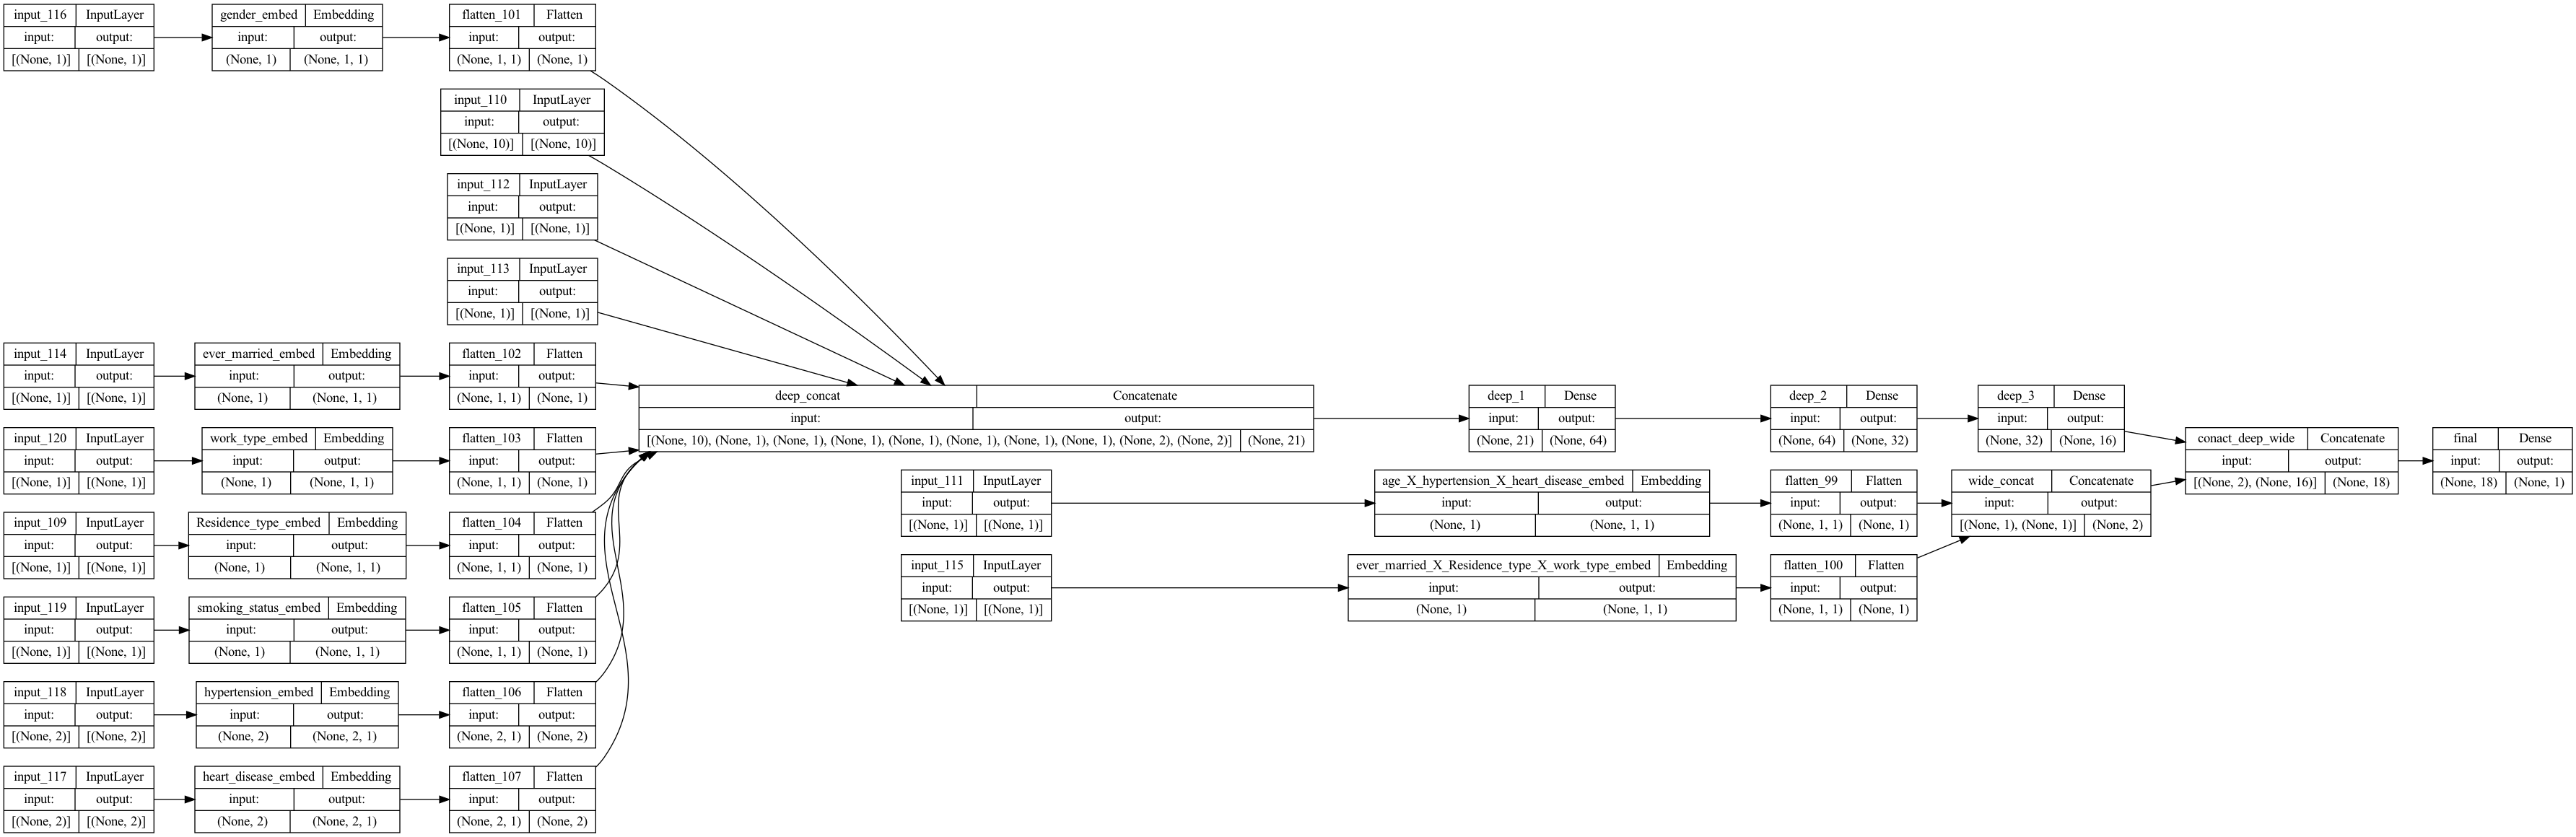

In [36]:
dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output
encoded_features = feature_space.get_encoded_features() # these features have been encoded

crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space.crossers.keys():
    
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    crossed_outputs.append(x)

wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

all_deep_branch_outputs = []

for col in numerical_headers:
    x = encoded_features[col]
    #x = tf.cast(x,float) # cast an integer as a float here
    all_deep_branch_outputs.append(x)

# for each categorical variable
for col in categorical_headers:
    
    # get the output tensor from ebedding layer
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    all_deep_branch_outputs.append(x)

deep_branch = Concatenate(name='deep_concat')(all_deep_branch_outputs)
deep_branch = Dense(64, activation='relu', name='deep_1')(deep_branch)
deep_branch = Dense(32, activation='relu', name='deep_2')(deep_branch)
deep_branch = Dense(16, activation='relu', name='deep_3')(deep_branch)

final_branch = Concatenate(name='conact_deep_wide')([wide_branch, deep_branch])
final_branch = Dense(1, activation='sigmoid', name='final')(final_branch)


metric = tf.keras.metrics.FBetaScore(beta=2.0, threshold=0.5)

training_model = Model(inputs=encoded_features, outputs=final_branch)
training_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

training_model.summary()

# non-encoded
inference_model = keras.Model(inputs=dict_inputs, outputs=final_branch)
inference_model.compile(loss='binary_crossentropy', metrics=['accuracy'])

plot_model(
    training_model, show_shapes=True, show_layer_names=True, to_file='model.png',
    rankdir='LR', expand_nested=False, dpi=96
)

In [37]:
history = training_model.fit(preprocessed_ds_train, epochs=10, validation_data=preprocessed_ds_test, verbose=2)

Epoch 1/10


2023-11-08 17:08:00.713922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-08 17:08:14.619178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 - 17s - loss: 0.3705 - accuracy: 0.8848 - val_loss: 0.1750 - val_accuracy: 0.9511 - 17s/epoch - 267ms/step
Epoch 2/10
64/64 - 2s - loss: 0.1682 - accuracy: 0.9513 - val_loss: 0.1609 - val_accuracy: 0.9511 - 2s/epoch - 28ms/step
Epoch 3/10
64/64 - 2s - loss: 0.1614 - accuracy: 0.9513 - val_loss: 0.1627 - val_accuracy: 0.9491 - 2s/epoch - 28ms/step
Epoch 4/10
64/64 - 2s - loss: 0.1611 - accuracy: 0.9506 - val_loss: 0.1583 - val_accuracy: 0.9501 - 2s/epoch - 29ms/step
Epoch 5/10
64/64 - 2s - loss: 0.1579 - accuracy: 0.9513 - val_loss: 0.1567 - val_accuracy: 0.9511 - 2s/epoch - 33ms/step
Epoch 6/10
64/64 - 2s - loss: 0.1588 - accuracy: 0.9511 - val_loss: 0.1595 - val_accuracy: 0.9511 - 2s/epoch - 26ms/step
Epoch 7/10
64/64 - 2s - loss: 0.1573 - accuracy: 0.9513 - val_loss: 0.1572 - val_accuracy: 0.9501 - 2s/epoch - 27ms/step
Epoch 8/10
64/64 - 2s - loss: 0.1575 - accuracy: 0.9513 - val_loss: 0.1569 - val_accuracy: 0.9511 - 2s/epoch - 25ms/step
Epoch 9/10
64/64 - 2s - loss: 0.1575 - a

Text(0.5, 0, 'epochs')

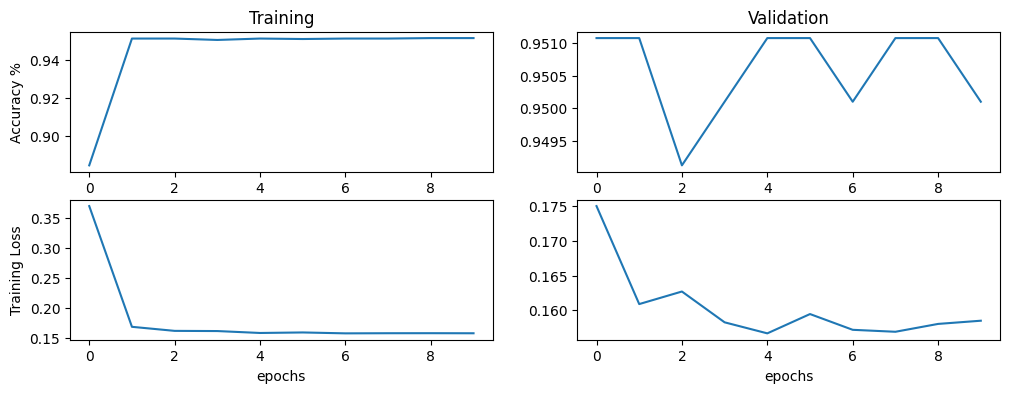

In [41]:
# Plot the training and validation accuracy and loss at each epoch

plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2, 2, 2)
plt.plot(history.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2, 2, 3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2, 2, 4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

#### Wide and Deep Network #2

The difference in this network is we made it wider by keeping the numerica and categorical data separate and then put them each through one dense layer. Then we combined them and put them through more dense layers.

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_32 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_30 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_36 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_25 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                            

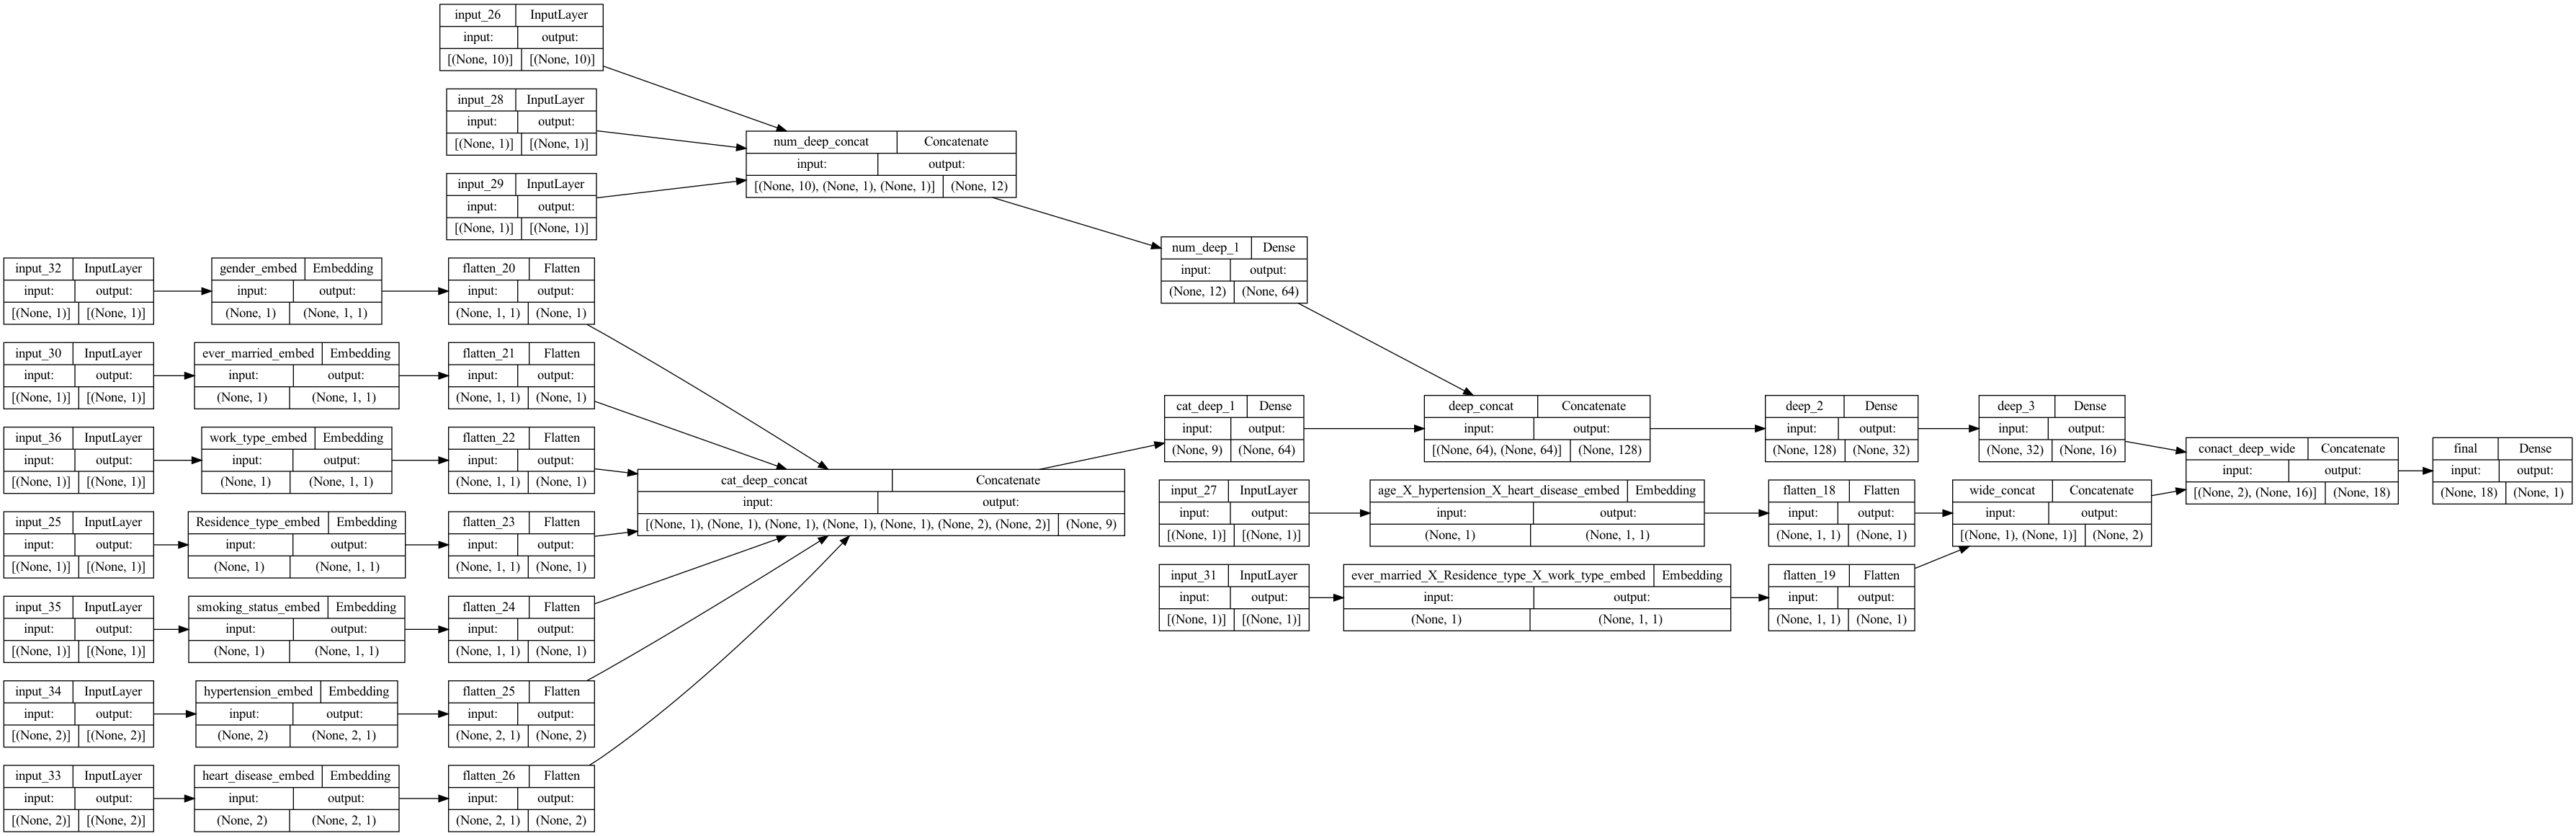

In [18]:
dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output
encoded_features = feature_space.get_encoded_features() # these features have been encoded

crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space.crossers.keys():
    
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    crossed_outputs.append(x)

wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

numeric_deep_branch_outputs = []
categorical_deep_branch_outputs = []

for col in numerical_headers:
    x = encoded_features[col]
    #x = tf.cast(x,float) # cast an integer as a float here
    numeric_deep_branch_outputs.append(x)

# for each categorical variable
for col in categorical_headers:
    
    # get the output tensor from ebedding layer
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    categorical_deep_branch_outputs.append(x)

num_deep_branch = Concatenate(name='num_deep_concat')(numeric_deep_branch_outputs)
num_deep_branch = Dense(64, activation='relu', name='num_deep_1')(num_deep_branch)

cat_deep_branch = Concatenate(name='cat_deep_concat')(categorical_deep_branch_outputs)
cat_deep_branch = Dense(64, activation='relu', name='cat_deep_1')(cat_deep_branch)

deep_branch = Concatenate(name='deep_concat')([num_deep_branch, cat_deep_branch])
deep_branch = Dense(32, activation='relu', name='deep_2')(deep_branch)
deep_branch = Dense(16, activation='relu', name='deep_3')(deep_branch)

final_branch = Concatenate(name='conact_deep_wide')([wide_branch, deep_branch])
final_branch = Dense(1, activation='sigmoid', name='final')(final_branch)

training_model = Model(inputs=encoded_features, outputs=final_branch)
training_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['fbeta_score'])

training_model.summary()

plot_model(
    training_model, show_shapes=True, show_layer_names=True, to_file='model.png',
    rankdir='LR', expand_nested=False, dpi=96
)

In [19]:
from sklearn.metrics import fbeta_score

training_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta_score(beta=2)])


Epoch 1/10


TypeError: in user code:

    File "/Users/wyattsaltzman/anaconda3/envs/ML23env/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Users/wyattsaltzman/anaconda3/envs/ML23env/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/wyattsaltzman/anaconda3/envs/ML23env/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Users/wyattsaltzman/anaconda3/envs/ML23env/lib/python3.8/site-packages/keras/src/engine/training.py", line 1085, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/Users/wyattsaltzman/anaconda3/envs/ML23env/lib/python3.8/site-packages/keras/src/engine/training.py", line 1179, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/Users/wyattsaltzman/anaconda3/envs/ML23env/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 605, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/Users/wyattsaltzman/anaconda3/envs/ML23env/lib/python3.8/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/Users/wyattsaltzman/anaconda3/envs/ML23env/lib/python3.8/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/Users/wyattsaltzman/anaconda3/envs/ML23env/lib/python3.8/site-packages/keras/src/metrics/base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)

    TypeError: 'str' object is not callable


#### Wide and Deep Network #3

The difference in this network is we decided to cross-product all our cateogrical features into one cross. We decided to do this because we didn't have a lot of categorical features plus this would cacpture all the interactions between the features in one go.

In [62]:
# Create the feature space with preprocessing steps applied and crossed features
feature_space = FeatureSpace(
    features={

        # Categorical features encoded as string
        'gender': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'ever_married': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'work_type': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'Residence_type': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'smoking_status': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),

        # Numerical features
        'age': FeatureSpace.float_discretized(num_bins=5),

        # Numerical features to normalize
        'avg_glucose_level': FeatureSpace.float_normalized(),
        'bmi': FeatureSpace.float_normalized(),

        # Categorical features encoded as integers
        'hypertension': FeatureSpace.integer_categorical(num_oov_indices=0),
        'heart_disease': FeatureSpace.integer_categorical(num_oov_indices=0),
    },
    crosses=[
        # create cross feature for all categorical features
        FeatureSpace.cross(feature_names=('gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'age',
                            'hypertension', 'heart_disease'), crossing_dim=2*2*5*2*5*10*2*2, output_mode='int'),
        # FeatureSpace.cross(feature_names=('age', 'hypertension', 'heart_disease'), crossing_dim=10*2*2, output_mode='int'), 
        # FeatureSpace.cross(feature_names=('ever_married', 'Residence_type', 'work_type'), crossing_dim=2*2*5, output_mode='int'),
        # FeatureSpace.cross(feature_names=('smoking_status', 'gender'), crossing_dim=5*2, output_mode='int'),
    ],
    output_mode='dict',
)

# Create a dataset with the feature space
ds_no_labels = ds.map(lambda x, _: x)
feature_space.adapt(ds_no_labels)
preprocessed_ds = ds.map(lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds = preprocessed_ds.prefetch(tf.data.AUTOTUNE)

2023-11-07 17:44:32.682631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-07 17:44:32.859867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-07 17:44:33.029115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-07 17:44:33.229544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-07 17:44:33.395817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-07 17:44:33.578139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-07 17:44:33.590809: I tensorflow/core/grappler/optimizers/cust

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 hypertension (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 heart_disease (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 gender (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 ever_married (InputLayer)   [(None, 1)]                  0         []                            
                                                                                           

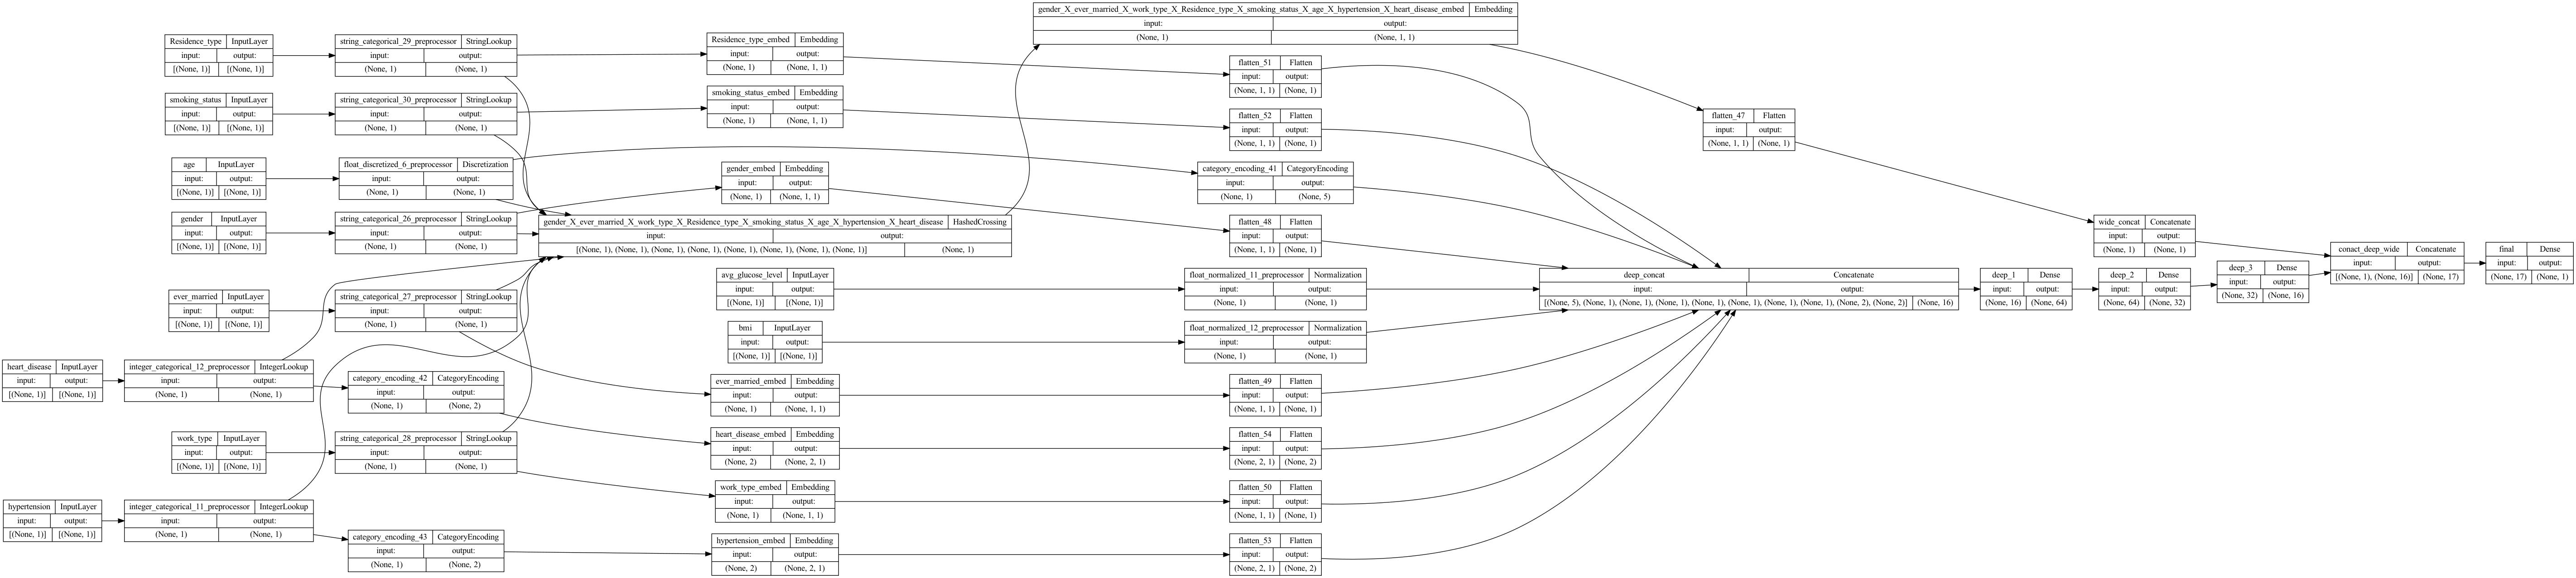

In [65]:
dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output
encoded_features = feature_space.get_encoded_features() # these features have been encoded

crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space.crossers.keys():
    
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    crossed_outputs.append(x)

wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

all_deep_branch_outputs = []

for col in numerical_headers:
    x = encoded_features[col]
    #x = tf.cast(x,float) # cast an integer as a float here
    all_deep_branch_outputs.append(x)

# for each categorical variable
for col in categorical_headers:
    
    # get the output tensor from ebedding layer
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    all_deep_branch_outputs.append(x)

deep_branch = Concatenate(name='deep_concat')(all_deep_branch_outputs)
deep_branch = Dense(64, activation='relu', name='deep_1')(deep_branch)
deep_branch = Dense(32, activation='relu', name='deep_2')(deep_branch)
deep_branch = Dense(16, activation='relu', name='deep_3')(deep_branch)

final_branch = Concatenate(name='conact_deep_wide')([wide_branch, deep_branch])
final_branch = Dense(1, activation='sigmoid', name='final')(final_branch)

training_model = Model(inputs=dict_inputs, outputs=final_branch)
training_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['fbeta_score'])

training_model.summary()

plot_model(
    training_model, show_shapes=True, show_layer_names=True, to_file='model.png',
    rankdir='LR', expand_nested=False, dpi=96
)